In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from operator import add, sub

np.random.seed(2017)

In [2]:
from pyspark import SparkContext

sc.stop()

SparkContext.setSystemProperty('spark.executor.memory', '2g')
SparkContext.setSystemProperty('spark.executor.cores', '4')

sc = SparkContext("local", "App Name")

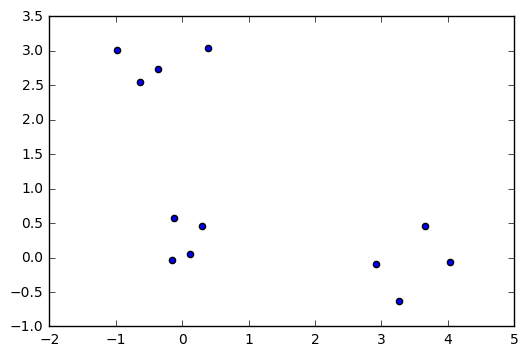

In [14]:
# Temporary cell. To be deleted later

N = 4

x_1 = np.random.multivariate_normal(mean = [0,0], cov = [[0.1,0],[0,0.1]], size = N)
x_2 = np.random.multivariate_normal(mean = [3,0], cov = [[0.3,-0.1],[-0.1,0.2]], size = N)
x_3 = np.random.multivariate_normal(mean = [0,3], cov = [[0.2,0],[0,0.2]], size = N)
N = 3 * N
X = np.concatenate((x_1, x_2, x_3))

plt.scatter(X[:,0], X[:,1])
plt.show()

pd.DataFrame(X).to_csv("gaussian_data.csv", sep="\t", header=None, index=True)

In [95]:
#Permet de convertir le RDD en Data Frame. On pourra directement créer un dataframe plus tard
from pyspark.sql.types import *

sql_c = SQLContext(sc)

lines = sc.textFile("gaussian_data.csv")
parts = lines.map(lambda l: l.split("\t"))

# Each line is converted to a tuple.
data = parts.map(lambda p: (int(p[0]), float(p[1]), float(p[2])))
#data = parts.map(lambda p: (float(p[1]), float(p[2])))

# Apply the schema to the RDD.
spark_data = sql_c.createDataFrame(data, schema=("index","x1","x2"))
#spark_data = sql_c.createDataFrame(data, schema=("x1","x2"))

In [96]:
spark_data.printSchema()

root
 |-- index: long (nullable = true)
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)



In [97]:
spark_data.show()

+-----+--------------------+--------------------+
|index|                  x1|                  x2|
+-----+--------------------+--------------------+
|    0| 0.29354767383937447|  0.4568056073684831|
|    1|-0.12124833116822087|  0.5752018260995152|
|    2| 0.12483458806722963| 0.05885954111875446|
|    3|-0.15259069394378327|-0.03033431797640859|
|    4|   4.024687578015456|-0.06000651655121...|
|    5|   3.257188478127214| -0.6338546652028731|
|    6|  2.9208445305373254|-0.09815585513762597|
|    7|   3.654916033718488| 0.46443393112851783|
|    8|  0.3961357113708628|  3.0348860538467664|
|    9|-0.36549091419397184|   2.733579893500002|
|   10| -0.9850700857682828|   3.009768190648289|
|   11| -0.6293522535439434|   2.546469901438722|
+-----+--------------------+--------------------+



In [98]:
#Cette instruction permet d'autoriser les produits cartésiens. Sinon, spark bloque
sql_c.setConf("spark.sql.crossJoin.enabled", True)

#L'instruction createOrReplaceTempView permet de créer uen View pour effectuer des opérations SQL
spark_data.createOrReplaceTempView("data")

sql_c.sql("SELECT  *  FROM data d1 JOIN data d2").show()

+-----+--------------------+------------------+-----+--------------------+--------------------+
|index|                  x1|                x2|index|                  x1|                  x2|
+-----+--------------------+------------------+-----+--------------------+--------------------+
|    0| 0.29354767383937447|0.4568056073684831|    0| 0.29354767383937447|  0.4568056073684831|
|    0| 0.29354767383937447|0.4568056073684831|    1|-0.12124833116822087|  0.5752018260995152|
|    0| 0.29354767383937447|0.4568056073684831|    2| 0.12483458806722963| 0.05885954111875446|
|    0| 0.29354767383937447|0.4568056073684831|    3|-0.15259069394378327|-0.03033431797640859|
|    0| 0.29354767383937447|0.4568056073684831|    4|   4.024687578015456|-0.06000651655121...|
|    0| 0.29354767383937447|0.4568056073684831|    5|   3.257188478127214| -0.6338546652028731|
|    0| 0.29354767383937447|0.4568056073684831|    6|  2.9208445305373254|-0.09815585513762597|
|    0| 0.29354767383937447|0.4568056073

In [101]:
#Permet de faire le produit cartésien. Je n'ai pas réussi à faire fonctionner la fonction pow() ou power(), donc je fait le carré manuellement
cartesian_similarities = sql_c.sql("SELECT d1.index as x1_index, d2.index as x2_index, -((d1.x1 - d2.x1) * (d1.x1 - d2.x1)) as similarity_x1, -((d1.x2 - d2.x2) * (d1.x2 - d2.x2)) as similarity_x2  FROM data d1 JOIN data d2")
#cartesian_similarities = sql_c.sql("SELECT -((d1.x1 - d2.x1) * (d1.x1 - d2.x1)) as similarity_x1, -((d1.x2 - d2.x2) * (d1.x2 - d2.x2)) as similarity_x2  FROM data d1 JOIN data d2")
cartesian_similarities.show()

+--------+--------+--------------------+--------------------+
|x1_index|x2_index|       similarity_x1|       similarity_x2|
+--------+--------+--------------------+--------------------+
|       0|       0|                -0.0|                -0.0|
|       0|       1|-0.17205572577026104| -0.0140176646098064|
|       0|       2| -0.0284641053107591| -0.1583610716436334|
|       0|       3|-0.19903944320822012| -0.2373053068650266|
|       0|       4| -13.921404984535101| -0.2670947714303925|
|       0|       5|  -8.783166816839874| -1.1895398301654252|
|       0|       6|  -6.902688773214934|-0.30798222486691945|
|       0|       7| -11.298797250796403|-5.81913233879107E-5|
|       0|       8|-0.01052430544456...| -6.6464987885136635|
|       0|       9| -0.4343318605169867|  -5.183701149989688|
|       0|      10|  -1.634863375184105|  -6.517617951626699|
|       0|      11| -0.8517442759641334|   -4.36669686191207|
|       1|       0|-0.17205572577026104| -0.0140176646098064|
|       

In [104]:
#Créer une View du produit cartésien
cartesian_similarities.createOrReplaceTempView("cartesian_similarities")

#Somme des similarités + création d'une view
sum_similarites = sql_c.sql("SELECT x1_index, x2_index, (similarity_x1 + similarity_x2) as similarity_without_diagonal FROM cartesian_similarities")
sum_similarites.createOrReplaceTempView("sum_similarites")

#Calcul de la médiane // On supprime les 0 et on calcule la médiane
sum_similarites_without_diagonal = sql_c.sql("SELECT *  FROM sum_similarites HAVING similarity_without_diagonal != 0")
sum_similarites.createOrReplaceTempView("sum_similarites_without_diagonal")

#Mediane est fausse
median = sum_similarites_without_diagonal.approxQuantile("similarity_without_diagonal", [0.5], 0)[0]

#Remplace la diagonale par la médiane
similarity_matrix = sql_c.sql("SELECT x1_index, x2_index, if(similarity_without_diagonal=0, '%s', similarity_without_diagonal) as similarities FROM sum_similarites" % median)
similarity_matrix.show()

+--------+--------+--------------------+
|x1_index|x2_index|        similarities|
+--------+--------+--------------------+
|       0|       0|  -8.930338103965866|
|       0|       1|-0.18607339038006745|
|       0|       2| -0.1868251769543925|
|       0|       3| -0.4363447500732467|
|       0|       4| -14.188499755965493|
|       0|       5|    -9.9727066470053|
|       0|       6|  -7.210670998081854|
|       0|       7| -11.298855442119791|
|       0|       8|  -6.657023093958226|
|       0|       9|  -5.618033010506675|
|       0|      10|  -8.152481326810804|
|       0|      11|  -5.218441137876203|
|       1|       0|-0.18607339038006745|
|       1|       1|  -8.930338103965866|
|       1|       2| -0.3271661583985944|
|       1|       3|-0.36765636548669295|
|       1|       4| -17.592274201631778|
|       1|       5|  -12.87565287356276|
|       1|       6|    -9.7077395461209|
|       1|       7| -14.271686837196548|
+--------+--------+--------------------+
only showing top

In [111]:
# Create A and R matrices
A = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
#A = sc.parallelize(range(N)).flatMap(lambda x1: [[x1, x2] for x2 in range(N)])
#R = sc.parallelize(range(N)).flatMap(lambda x1: [[x1, x2] for x2 in range(N)])
R = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])

# Each line is converted to a tuple.
#A = A.map(lambda p: ((x,y), float(0)))
#R = R.map(lambda p: (x, y , float(0), float(0)))

# Apply the schema to the RDD.
#A_spark = sql_c.createDataFrame(A, schema=("x1_index","x2_index","x1","x2"))
#R_spark = sql_c.createDataFrame(R, schema=("x1_index","x2_index","x1","x2"))

lambdaValue = 0.5
A.collect()

[((0, 0), 0),
 ((0, 1), 0),
 ((0, 2), 0),
 ((0, 3), 0),
 ((0, 4), 0),
 ((0, 5), 0),
 ((0, 6), 0),
 ((0, 7), 0),
 ((0, 8), 0),
 ((0, 9), 0),
 ((0, 10), 0),
 ((0, 11), 0),
 ((1, 0), 0),
 ((1, 1), 0),
 ((1, 2), 0),
 ((1, 3), 0),
 ((1, 4), 0),
 ((1, 5), 0),
 ((1, 6), 0),
 ((1, 7), 0),
 ((1, 8), 0),
 ((1, 9), 0),
 ((1, 10), 0),
 ((1, 11), 0),
 ((2, 0), 0),
 ((2, 1), 0),
 ((2, 2), 0),
 ((2, 3), 0),
 ((2, 4), 0),
 ((2, 5), 0),
 ((2, 6), 0),
 ((2, 7), 0),
 ((2, 8), 0),
 ((2, 9), 0),
 ((2, 10), 0),
 ((2, 11), 0),
 ((3, 0), 0),
 ((3, 1), 0),
 ((3, 2), 0),
 ((3, 3), 0),
 ((3, 4), 0),
 ((3, 5), 0),
 ((3, 6), 0),
 ((3, 7), 0),
 ((3, 8), 0),
 ((3, 9), 0),
 ((3, 10), 0),
 ((3, 11), 0),
 ((4, 0), 0),
 ((4, 1), 0),
 ((4, 2), 0),
 ((4, 3), 0),
 ((4, 4), 0),
 ((4, 5), 0),
 ((4, 6), 0),
 ((4, 7), 0),
 ((4, 8), 0),
 ((4, 9), 0),
 ((4, 10), 0),
 ((4, 11), 0),
 ((5, 0), 0),
 ((5, 1), 0),
 ((5, 2), 0),
 ((5, 3), 0),
 ((5, 4), 0),
 ((5, 5), 0),
 ((5, 6), 0),
 ((5, 7), 0),
 ((5, 8), 0),
 ((5, 9), 0),
 ((5, 10),

In [66]:
#A_spark.withColumn('x1', '2')
#similarity_matrix + A_spark

#cols = ['x1', 'x2', 'x1_A', 'x2_A']    

x1 = sql_c.read.parquet("SELECT ")
#df_1_new = similarity_matrix.withColumn("x1", A_spark.columns)

#.select(cols)
#df_2_new = df_2.withColumn("normal", lit(None)).select(cols)

#result = df_1_new.unionAll(df_2_new)

AssertionError: col should be Column

In [6]:
def computeR(A, R, S, N):
    # Compute the sum of A and S
    sumA_S = sc.sparkContext.union([A, S]).reduceByKey(add)

    # Remove all rows where i == k and compute the maximum
    tmp = sc.sparkContext.parallelize(range(N)).cartesian(sumA_S)
    tmp = tmp.map(lambda row: (row[0], (row[1][0][1], (row[1][0][0], row[1][1])))).filter(lambda row: row[1][0] != row[0])
    maximum = tmp.map(lambda row: ((row[1][1][0], row[0]), row[1][1][1])).reduceByKey(max)

    # Compute r
    r = sc.sparkContext.union([S, maximum]).reduceByKey(sub)

    # Compute R
    R = R.join(r).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return R

In [7]:
def computeA(A, R, N):
    # Remove all rows where i == k and compute the maximum
    tmp = R.filter(lambda row: row[0][0] != row[0][1])
    tmp = sc.sparkContext.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][0] and row[0] != row[1][0][1])
    maximum = tmp.map(lambda row: (row[1][0], max(0, row[1][1]))).reduceByKey(add)

    # Add R[k, k]
    tmp = maximum.map(lambda row: ((row[0][1], row[0][1]), row)).join(R.filter(lambda row: row[0][0] == row[0][1]))
    a = tmp.map(lambda row: (row[1][0][0], min(0, row[1][0][1] + row[1][1])))

    # Compute the value of a when i == k
    tmp = R.filter(lambda row: row[0][0] == row[0][1])
    tmp = sc.sparkContext.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][1])
    maximum = tmp.map(lambda row: (row[1][0], max(0, row[1][1]))).reduceByKey(add)

    # Join both RDDs
    a = sc.sparkContext.union([a, maximum])

    # Compute A
    A = A.join(a).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return A

In [9]:
iterations = 10
for iter in range(iterations):
    if iter % 2 == 0:
        print(iter, "iterations done")
    # Update r(i, k) given a(i, k)
    R = computeR(A, R, S, N)
    
    # Update a(i, k) given r(i, k)
    A = computeA(A, R, N)

0 iterations done
2 iterations done


Py4JJavaError: An error occurred while calling o916.partitions.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.lang.Integer.valueOf(Unknown Source)
	at scala.runtime.BoxesRunTime.boxToInteger(BoxesRunTime.java:65)
	at scala.collection.IndexedSeqOptimized$class.zipWithIndex(IndexedSeqOptimized.scala:103)
	at scala.collection.mutable.ArrayOps$ofRef.zipWithIndex(ArrayOps.scala:186)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:249)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:246)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:246)
	at org.apache.spark.api.java.JavaRDDLike$class.partitions(JavaRDDLike.scala:60)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.GeneratedMethodAccessor41.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)
